In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

# display image
def display_image(image, title='Image'):
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def binarize_image(image):
	_, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	return binarized


def crop_to_bounding_box(image, padding=10):
    # Invert the grayscale image to make black pixels white (255)
    inverted_gray = cv2.bitwise_not(image)

    # Apply a binary threshold to the inverted grayscale image
    _, binary = cv2.threshold(inverted_gray, 1, 255, cv2.THRESH_BINARY)

    # Find coordinates of all non-zero pixels
    coords = np.column_stack(np.where(binary > 0))

    # Get the bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the bounding box from the original image
    cropped_image = image[x_min:x_max, y_min:y_max]
    # cropped_image = image[x_min - padding:x_max + padding, y_min - padding:y_max + padding]

    # pad image
    padded_image = cv2.copyMakeBorder(cropped_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=255)

    return padded_image


# count disconnected components
def disconnected_components(image):
	# Invert the image to make black pixels white (255)
	inverted = cv2.bitwise_not(image)

	# Find connected components
	num_labels, labels = cv2.connectedComponents(inverted)

	# show connected components
	image_with_components = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
	from matplotlib.cm import Set1 as color_map
	for label in range(1, num_labels):
		image_with_components[labels == label] = np.array(color_map(label)[:3]) * 255
	# display_image(image_with_components, title='Disconnected Components')

	return num_labels - 1

def perimetric_complexity(image):
    # Invert the image to make black pixels white (255)
    image = cv2.bitwise_not(image)

    # Find the contours of the character (foreground)
    contours, _ = cv2.findContours(image, cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # print(f'Number of contours: {len(contours)}')

    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) * 0

    # Highlight the skeleton with different colors
    from matplotlib.cm import Set1 as color_map
    for i, contour in enumerate(contours):
        color = np.array(color_map(i)[:3]) * 255
        cv2.drawContours(image_with_contours, [contour], -1, color, 3)

    # display_image(image_with_contours, title='Contours')

    # Calculate the perimeter (P) of the character
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, True)

    # Calculate the area (A) of the character
    # area = 0
    # for contour in contours:
    #     area += cv2.contourArea(contour)

    area = np.sum(image == 255)

    # print(f'Area: {area:.2f} sq. px')
    # print(f'Perimeter: {perimeter:.2f} px')

    # Calculate the Perimetric Complexity (PC)
    if area != 0:
        perimetric_complexity = (perimeter**2) / (area * 4 * np.pi)
    else:
        perimetric_complexity = float('inf')

    return perimetric_complexity


In [2]:
from main3 import *
import pandas as pd
from tqdm import tqdm

In [3]:
TELUGU_FONT = './fonts/NotoSansTelugu-Regular.ttf'
# TELUGU_FONT = './fonts/NATS.ttf'
ENGLISH_FONT = './fonts/NotoSans-Regular.ttf'

In [4]:
def generate_image(string):
	font = ImageFont.truetype(TELUGU_FONT, 250)
	# font = ImageFont.truetype(ENGLISH_FONT, 250)
	
	image = Image.new('RGB', (500, 500), 'white')
	draw = ImageDraw.Draw(image)
	draw.text((0, 0), string, (0, 0, 0), font=font)
	# image.save(os.path.join(folder, f'image_{string}.png'))
	# plt.axis('off')
	# plt.imshow(image)
	# plt.show()

	return image

In [5]:
import concurrent.futures

In [6]:
# # for 200 words calculate ONs and graphic complexity and plot correlation

# words200 = list(Dictionary('dicts/test.txt.dict').words)

# dictionaries = [
#         # Dictionary('dicts/telugu.lemma.txt.dict'),
#         # Dictionary('dicts/telugu.lex.txt.dict'),
#         # Dictionary('dicts/sortdict.txt.dict'),
#         # Dictionary('dicts/test.txt.dict'),
#         # Dictionary('dicts/dictionary.sqlite.dict'),
#         Dictionary('dicts/cpbrown.txt.dict'),
#         Dictionary('dicts/cpbrown_meanings.txt.dict'),
#     ]

# # generate_orthographic_neighbors2(words200[0])

# def process_word(word):
#     """Process a single word to get ON count and perimetric complexity."""
#     on_count = len(generate_orthographic_neighbors2(word))
#     image = generate_image(word)
#     image = np.array(image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = binarize_image(image)
#     image = crop_to_bounding_box(image)
#     pc = perimetric_complexity(image)
#     dc = disconnected_components(image)
#     return (word, on_count, pc, dc)

# words_measures = []

# # Using ThreadPoolExecutor to process words in parallel
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(process_word, word) for word in words200]
#     for future in tqdm(concurrent.futures.as_completed(futures), total=len(words200)):
#         words_measures.append(future.result())

# # Create DataFrame and save results
# df = pd.DataFrame(words_measures, columns=['word', 'on', 'pc', 'dc'])
# df.to_csv('words_measures_pc_dc.csv', index=False)

# df

In [7]:
# # df = pd.read_csv('words_measures.csv')
# df = pd.read_csv('words_measures_pc_dc.csv')
# df.head()

In [8]:
# # calculate sf and cp using syllables

# syllables = pd.read_csv('200_aksharas_gc.csv')
# syllables.head()

In [9]:
# def get_combined_sf_cp(word):
# 	aksharas = syllabify(word)
# 	sf = 0
# 	cp = 0
# 	for akshara in aksharas:
# 		syllables_row = syllables[syllables['akshara'] == akshara]
# 		sf += int(syllables_row['sf'].values[0])
# 		cp += int(syllables_row['cp'].values[0])
# 		# print(akshara, sf, cp)
# 	return sf, cp

# get_combined_sf_cp('చుట్టూ')

In [10]:

# # add sf and cp columns to df
# df['sf'] = 0
# df['cp'] = 0

# for i, row in df.iterrows():
# 	word = row['word']
# 	sf, cp = get_combined_sf_cp(word)
# 	df.at[i, 'sf'] = sf
# 	df.at[i, 'cp'] = cp

# df

# # df.to_csv('200_words_gc.csv', index=False)

In [11]:
# # add syllable structure column
# for i, row in df.iterrows():
# 	word = row['word']
# 	syllable_structure, syllable_breakup = infer_syllable_structure(
# 		word, return_breakup=True)
# 	df.at[i, 'syllable_structure'] = syllable_structure
# 	df.at[i, 'syllable_breakup'] = syllable_breakup
# df

In [12]:
df = pd.read_csv('200_words_gc_syllable.csv')
df.head()

word   on         pc  dc  sf  cp syllable_structure syllable_breakup
0  చుట్టూ   24  32.215915   4  15  12          C1V.C1C1V          చు.ట్టూ
1   స్వయం    7  31.568439   4   9   4         C1C2V.C1Vm           స్వ.యం
2    చేసి   88  23.361500   3   8   5            C1V.C1V            చే.సి
3     అను  198  23.686128   2   6   4              V.C1V             అ.ను
4     ఇదే   62  21.637085   2   8   5              V.C1V             ఇ.దే

In [13]:

# further group syllable structures into 3 categories
# 1. simple
# 2. moderate
# 3. complex

# cluster into 3 based on [pc, dc, sf, cp]

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

K = 3
features = ['pc', 'dc', 'sf', 'cp']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=K, random_state=0)
df['cluster'] = kmeans.fit_predict(X_scaled)

# match cluster names with cluster numbers, based on the mean PC values
mean_pc = df.groupby('cluster')['pc'].mean()
mean_pc = mean_pc.sort_values()
cluster_names = ['simple', 'moderate', 'complex']
cluster_mapping = dict(zip(mean_pc.index, cluster_names))
df['cluster'] = df['cluster'].map(cluster_mapping)
df

word   on         pc  dc  sf  cp syllable_structure syllable_breakup  \
0    చుట్టూ   24  32.215915   4  15  12          C1V.C1C1V          చు.ట్టూ   
1     స్వయం    7  31.568439   4   9   4         C1C2V.C1Vm           స్వ.యం   
2      చేసి   88  23.361500   3   8   5            C1V.C1V            చే.సి   
3       అను  198  23.686128   2   6   4              V.C1V             అ.ను   
4       ఇదే   62  21.637085   2   8   5              V.C1V             ఇ.దే   
..      ...  ...        ...  ..  ..  ..                ...              ...   
193   వస్తే   98  25.655380   4   8   4          C1V.C1C2V           వ.స్తే   
194  దాన్ని   62  29.376395   3   9   5          C1V.C1C1V          దా.న్ని   
195     పది  146  19.521256   3   6   3            C1V.C1V             ప.ది   
196   ఇల్లు   99  26.795405   3   9   5            V.C1C1V           ఇ.ల్లు   
197    రంగు  102  24.051293   3   6   3           C1Vm.C1V            రం.గు   

      cluster  
0     complex  
1    moderate  
2    moderate  
3      simple  
4      simple  
..        ...  
193  moderate  
194  moderate  
195    simple  
196  moderate  
197    simple  

[198 rows x 9 columns]

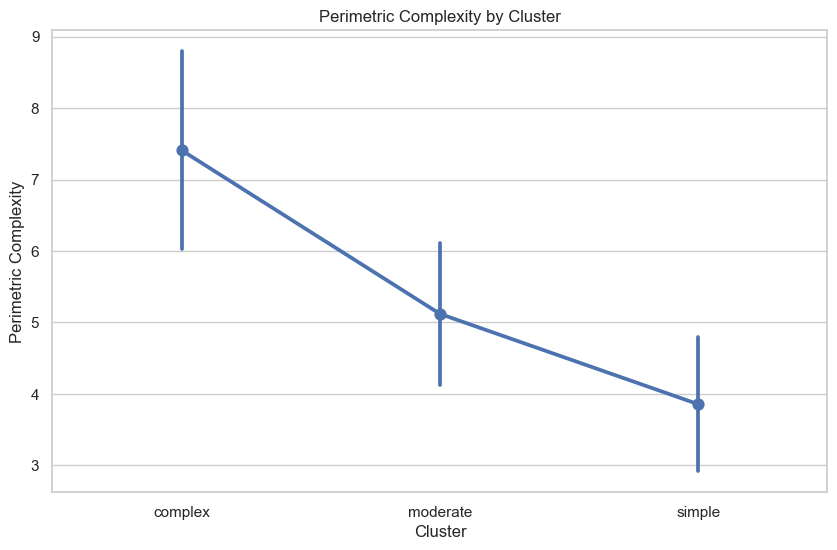

In [14]:
# point plots

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.pointplot(x='cluster', y='cp', data=df, errorbar='sd')
plt.ylabel('Perimetric Complexity')
plt.xlabel('Cluster')
plt.title('Perimetric Complexity by Cluster')
plt.show()

In [15]:
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname=TELUGU_FONT)

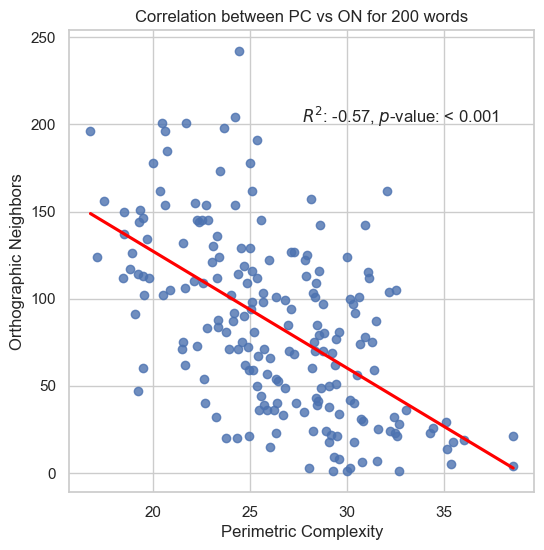

In [16]:
# plot correlation and linear regression

import seaborn as sns
sns.set_theme(style='whitegrid')
plt.figure(figsize=(6, 6))
sns.regplot(x='pc', y='on', data=df, ci=None, line_kws={'color': 'red'})
plt.xlabel('Perimetric Complexity')
plt.ylabel('Orthographic Neighbors')
plt.title('Correlation between PC vs ON for 200 words')

# R^2 correlation, p-value
from scipy.stats import pearsonr
r, p = pearsonr(df['pc'], df['on'])
plt.text(0.5, 0.8, f'$R^2$: {r:.2f}, $p$-value: < 0.001', fontsize=12, transform=plt.gca().transAxes)
plt.show()

In [23]:
# Plot the correlation between x and y

def plot_correlation(df, x, y, xlabel, ylabel, title):
	import seaborn as sns
	sns.set_theme(style='whitegrid')
	plt.figure(figsize=(6, 6), dpi=600)
	# sns.scatterplot(data=df, x=x, y=y)
	sns.regplot(x=x, y=y, data=df, ci=None, line_kws={'color': 'red'})
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.title(title)

	# examples
	lowest_pc = df.loc[df[x].idxmin()].word
	highest_pc = df.loc[df[x].idxmax()].word
	lowest_ons = df.loc[df[y].idxmin()].word
	highest_ons = df.loc[df[y].idxmax()].word
	nearest_to_mean = df.iloc[(df[x] - df[x].mean()).abs().argsort()[:1]].word.values[0]
	nearest_to_median = df.iloc[(df[x] - df[x].median()).abs().argsort()[:1]].word.values[0]
	print(f'{lowest_pc=}, {highest_pc=}, {lowest_ons=}, {highest_ons=} {nearest_to_mean=} {nearest_to_median=}')
	# TODO: plot images for examples on the plot

	# R^2 correlation, p-value
	from scipy.stats import pearsonr
	r, p = pearsonr(df[x], df[y])
	p_value_text = f"$p$-value: < 0.001" if p < 0.001 else f"$p$-value: {p:.2}"
	plt.text(0.5, 0.8, f'$R^2$: {r:.2f}, {p_value_text}', fontsize=12, transform=plt.gca().transAxes)
	plt.show()

lowest_pc='అను', highest_pc='స్పష్టం', lowest_ons='త్యాగం', highest_ons='అతి' nearest_to_mean='రంగు' nearest_to_median='రంగు'


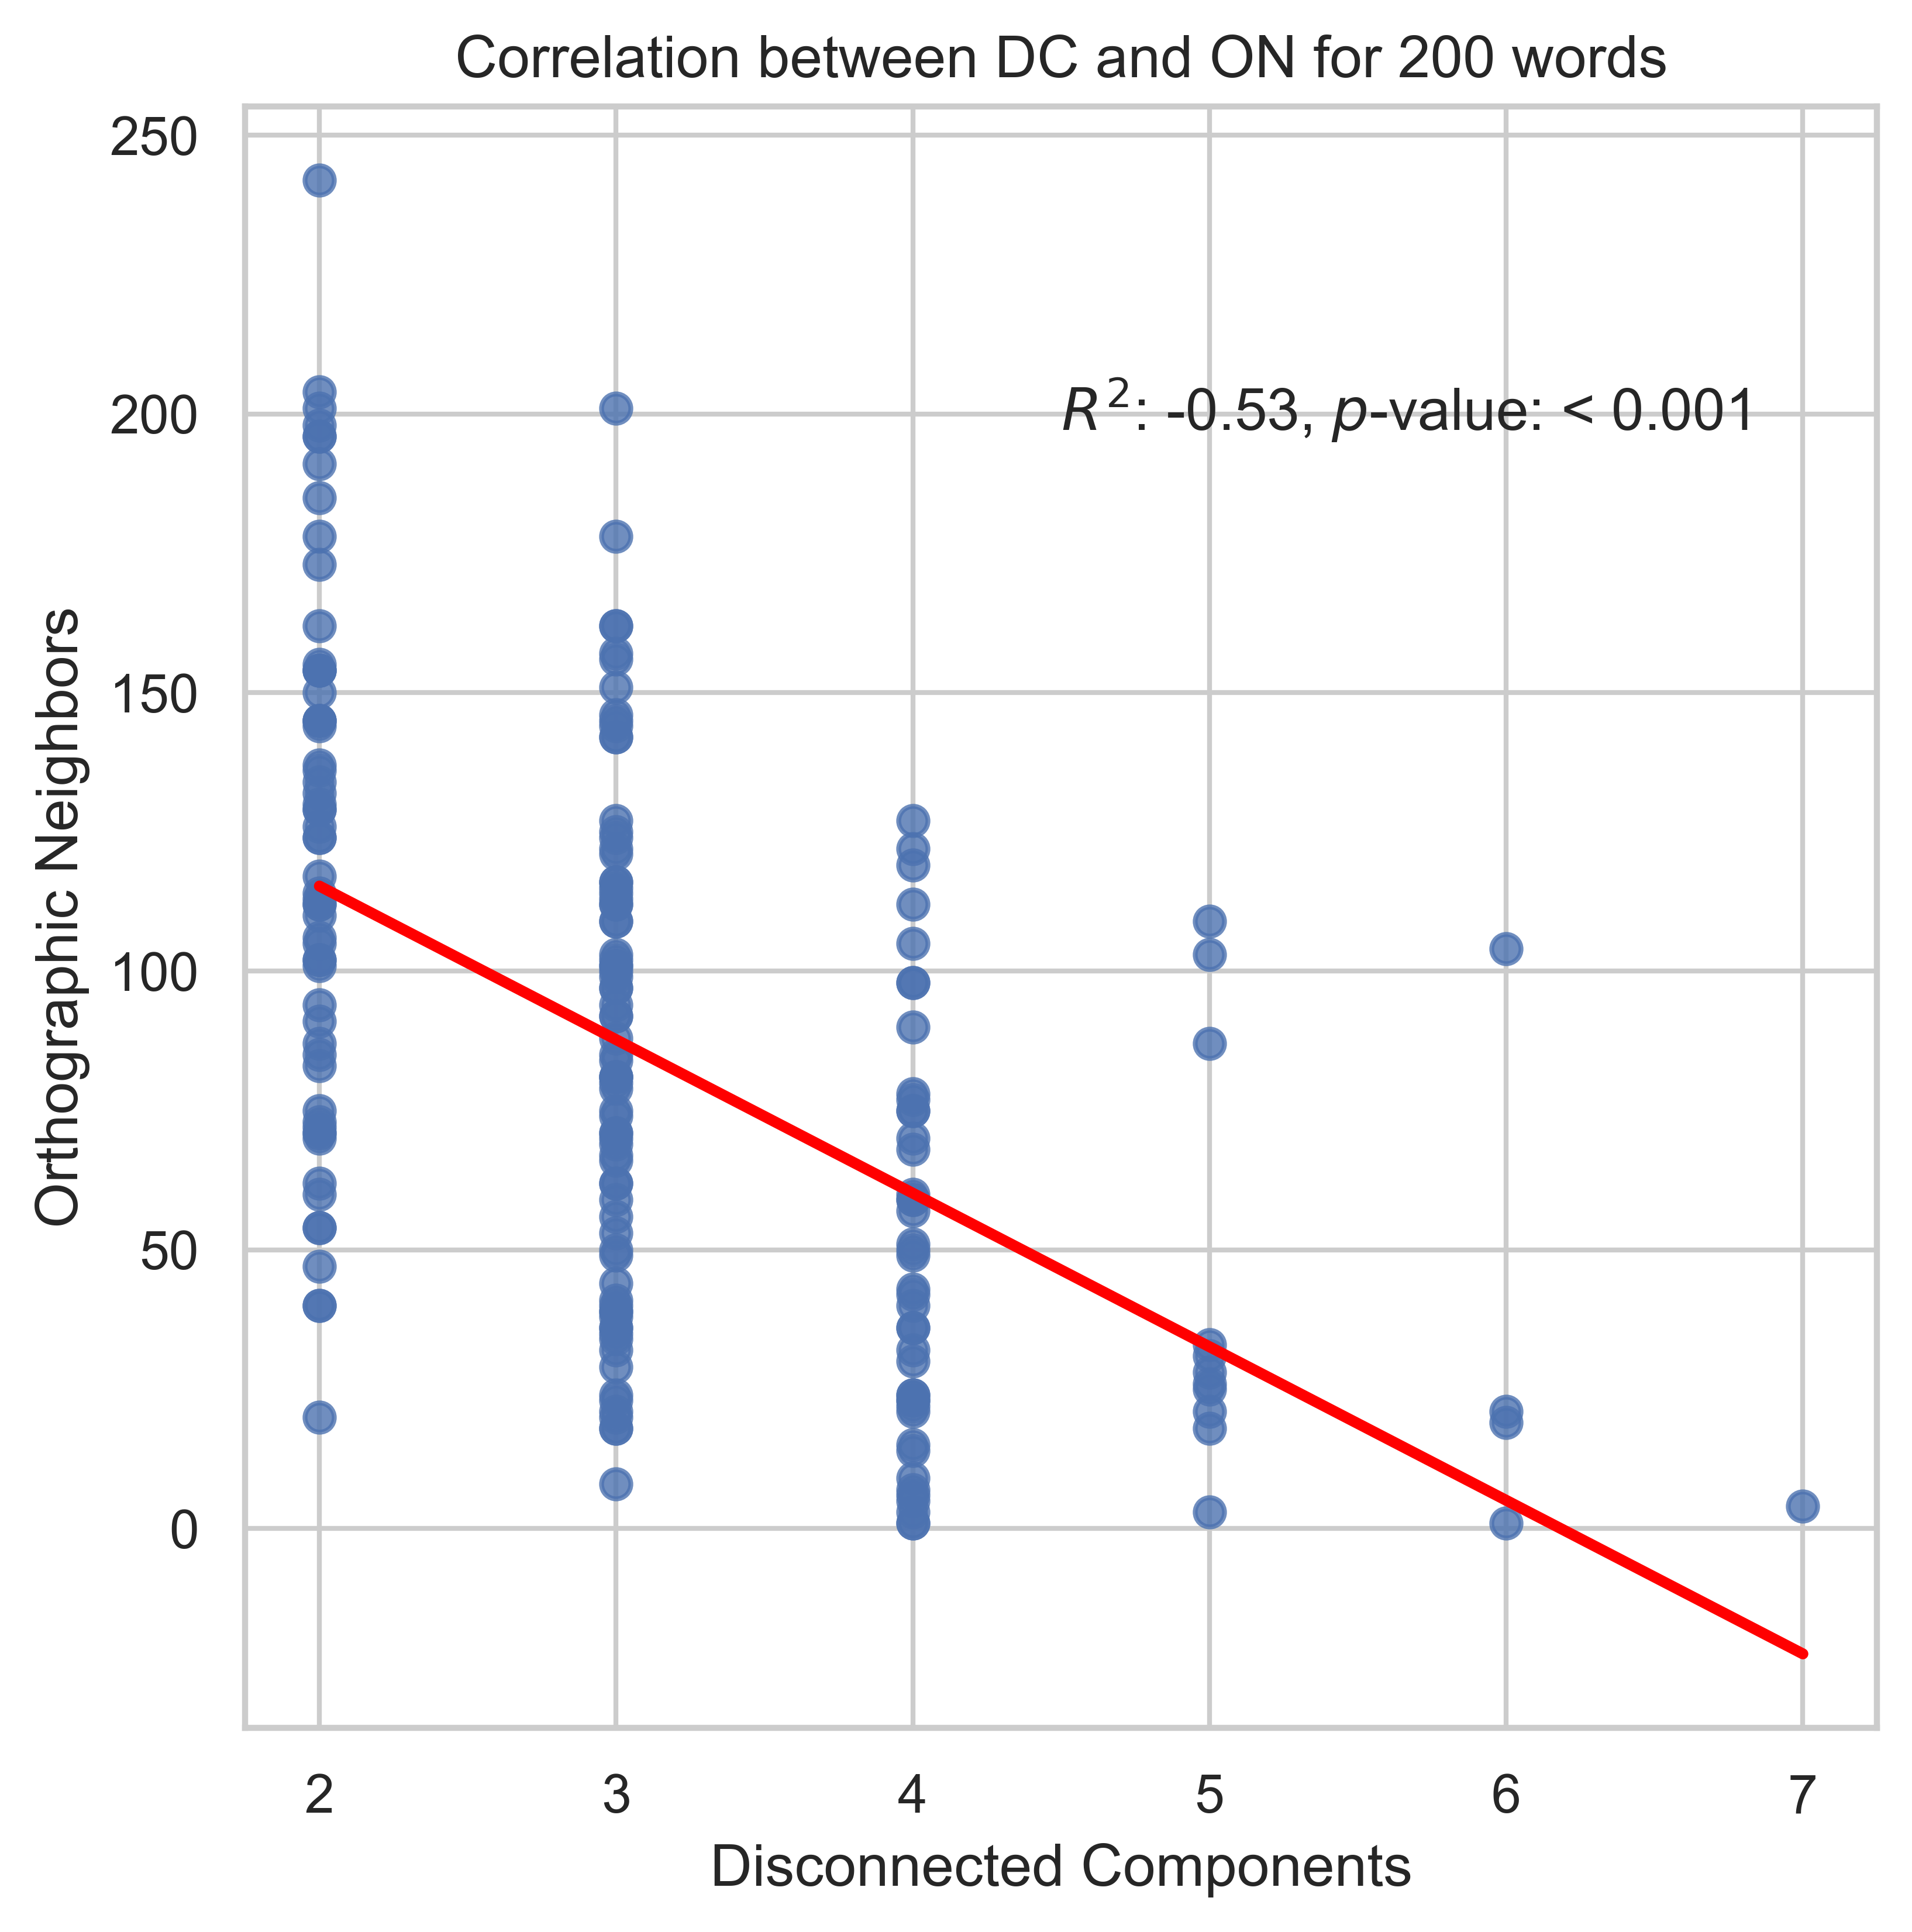

lowest_pc='కల', highest_pc='స్పష్టం', lowest_ons='త్యాగం', highest_ons='అతి' nearest_to_mean='కూడా' nearest_to_median='భాగం'


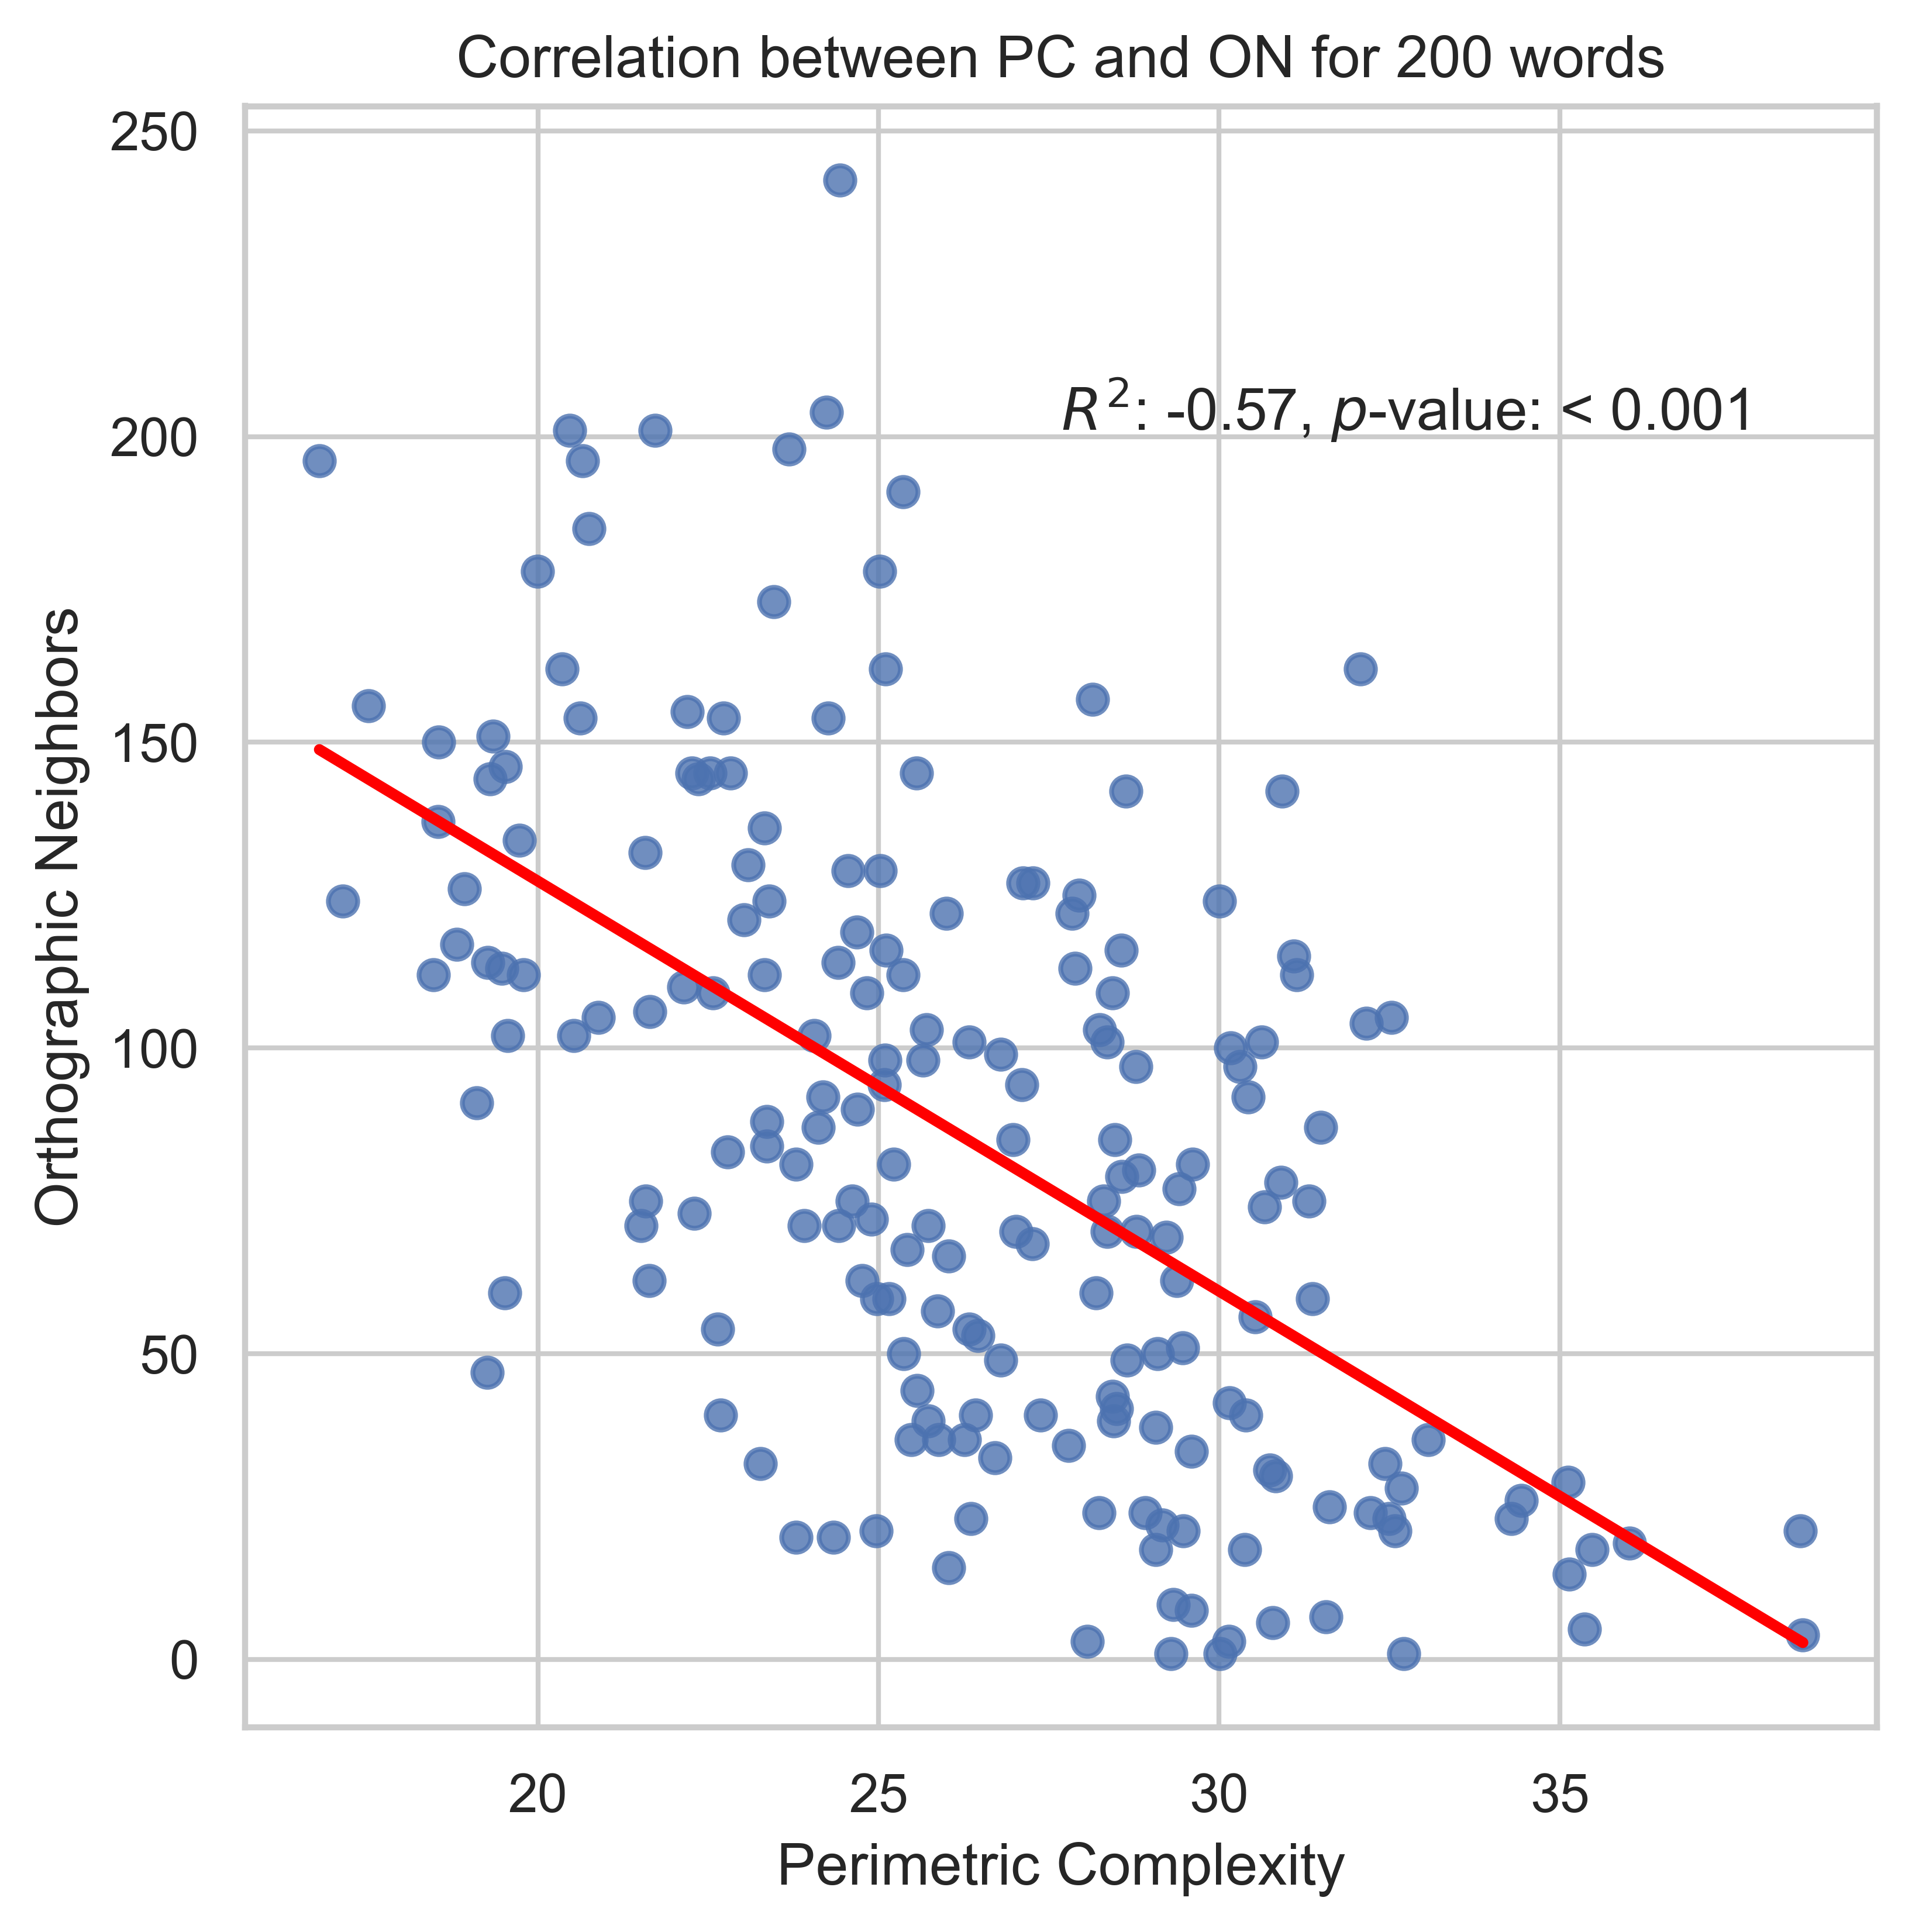

lowest_pc='సరి', highest_pc='చుట్టూ', lowest_ons='త్యాగం', highest_ons='అతి' nearest_to_mean='కొత్త' nearest_to_median='శ్రమ'


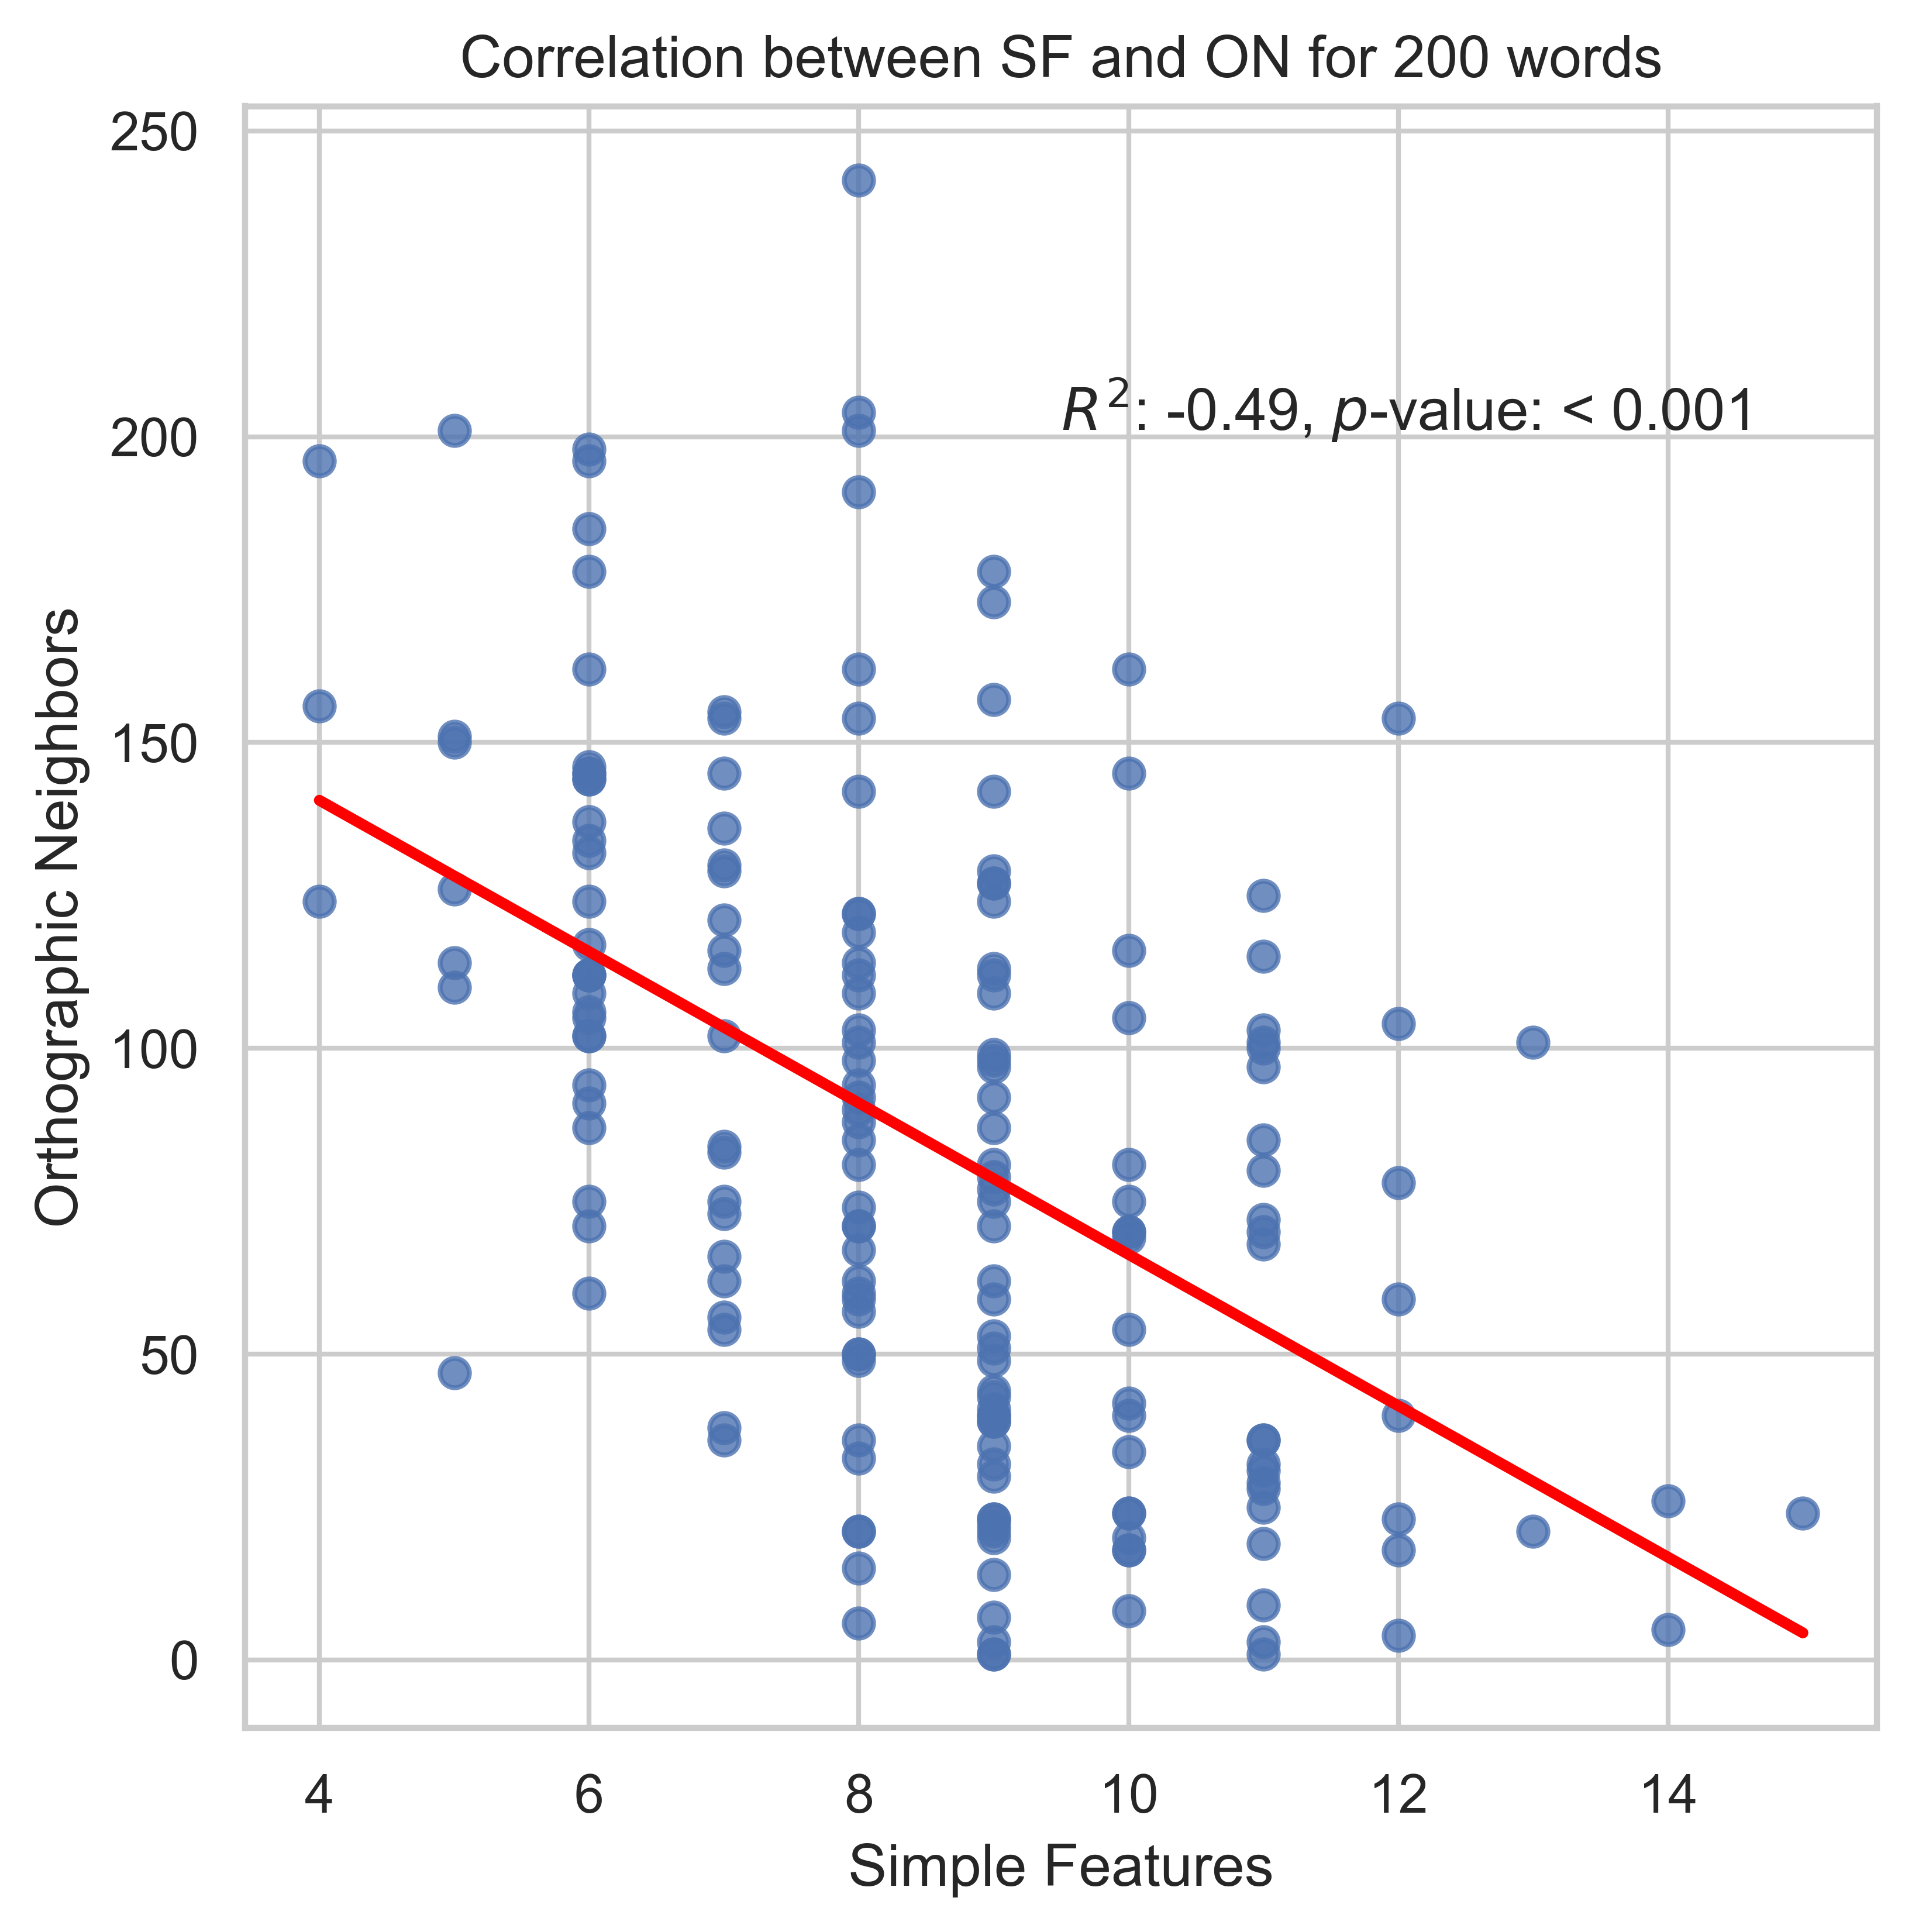

lowest_pc='సరి', highest_pc='చుట్టూ', lowest_ons='త్యాగం', highest_ons='అతి' nearest_to_mean='ఇల్లు' nearest_to_median='వంట'


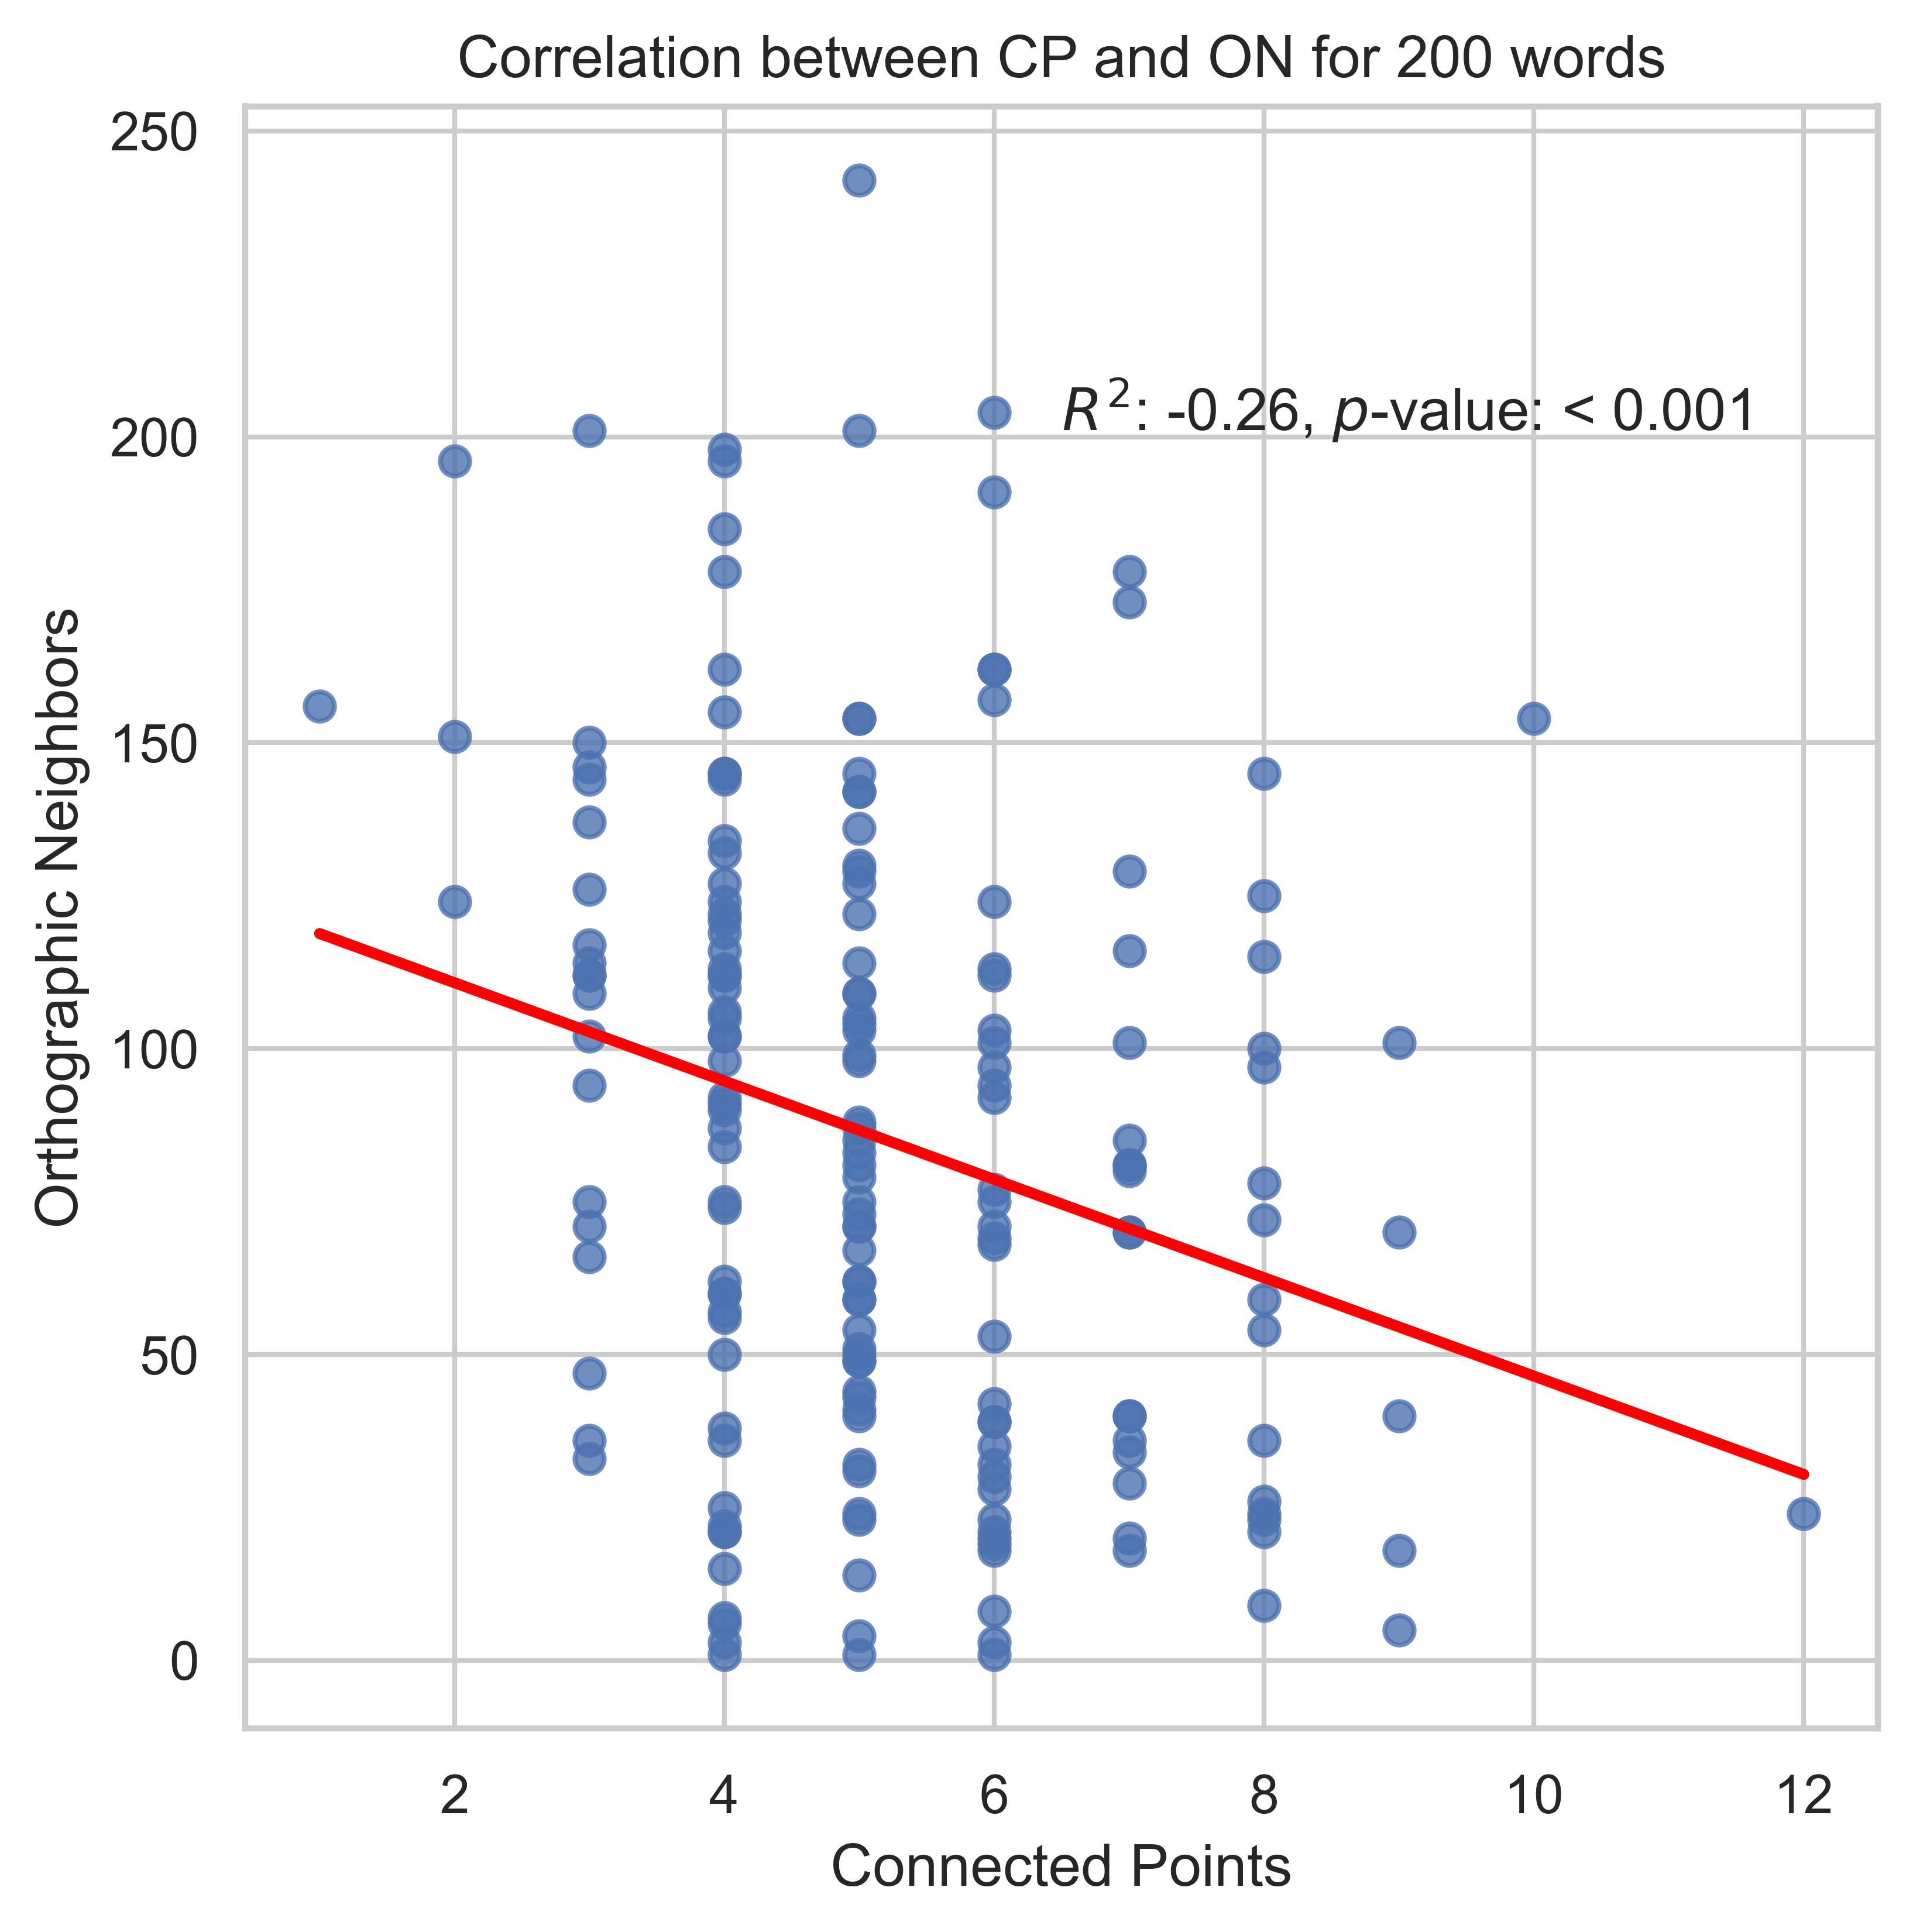

In [24]:
# Plot the correlation between DC and ON
plot_correlation(df, 'dc', 'on', 'Disconnected Components', 'Orthographic Neighbors', 'Correlation between DC and ON for 200 words')
# Plot the correlation between PC and ON
plot_correlation(df, 'pc', 'on', 'Perimetric Complexity', 'Orthographic Neighbors', 'Correlation between PC and ON for 200 words')
# Plot the correlation between SF and ON
plot_correlation(df, 'sf', 'on', 'Simple Features', 'Orthographic Neighbors', 'Correlation between SF and ON for 200 words')
# Plot the correlation between CP and ON
plot_correlation(df, 'cp', 'on', 'Connected Points', 'Orthographic Neighbors', 'Correlation between CP and ON for 200 words')

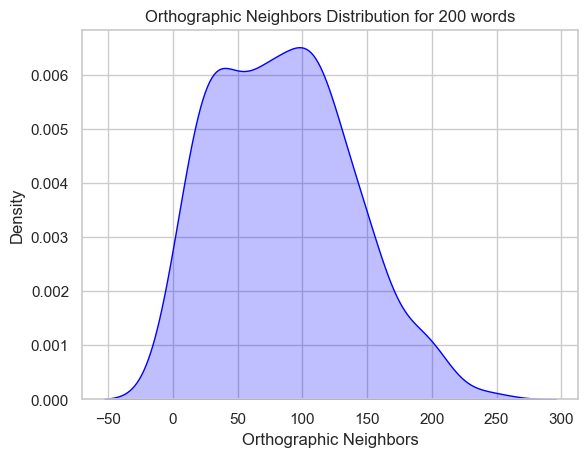

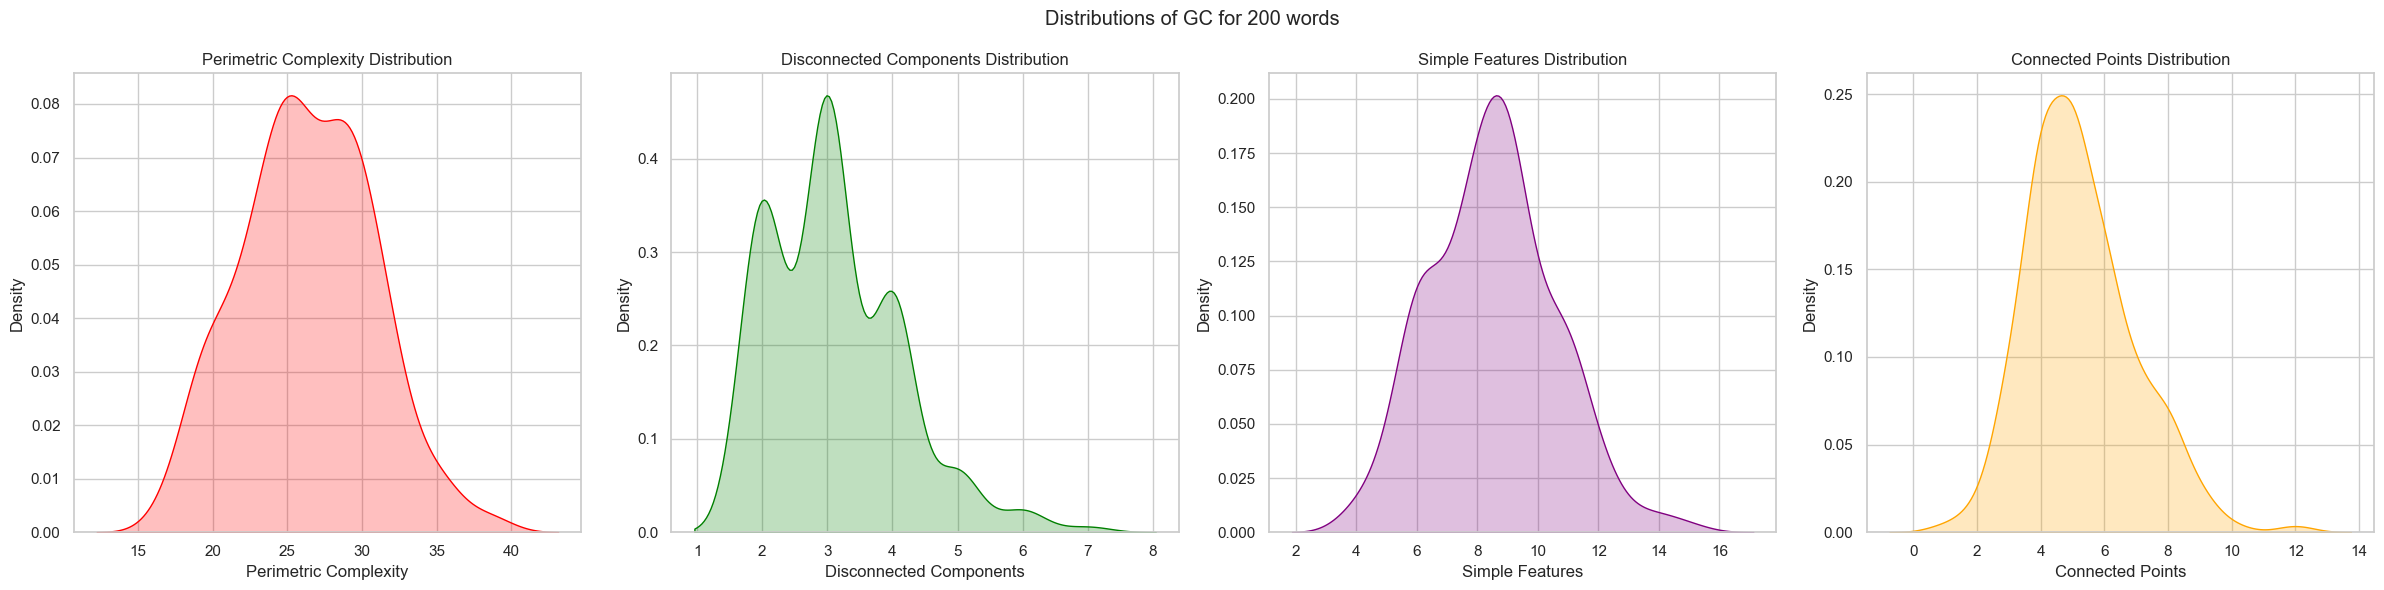

In [57]:
# plot all distributions as KDE

sns.set_style('whitegrid')

sns.kdeplot(df['on'], color='blue', label='Orthographic Neighbors', fill=True)
plt.title('Orthographic Neighbors Distribution for 200 words')
plt.xlabel('Orthographic Neighbors')
plt.ylabel('Density')
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(24, 6))

sns.kdeplot(df['pc'], ax=ax[0], color='red', label='Perimetric Complexity', fill=True)
ax[0].set_title('Perimetric Complexity Distribution')
ax[0].set_xlabel('Perimetric Complexity')
ax[0].set_ylabel('Density')

sns.kdeplot(df['dc'], ax=ax[1], color='green', label='Disconnected Components', fill=True)
ax[1].set_title('Disconnected Components Distribution')
ax[1].set_xlabel('Disconnected Components')
ax[1].set_ylabel('Density')

sns.kdeplot(df['sf'], ax=ax[2], color='purple', label='Simple Features', fill=True)
ax[2].set_title('Simple Features Distribution')
ax[2].set_xlabel('Simple Features')
ax[2].set_ylabel('Density')

sns.kdeplot(df['cp'], ax=ax[3], color='orange', label='Connected Points', fill=True)
ax[3].set_title('Connected Points Distribution')
ax[3].set_xlabel('Connected Points')
ax[3].set_ylabel('Density')

plt.suptitle('Distributions of GC for 200 words')
plt.tight_layout()
plt.show()

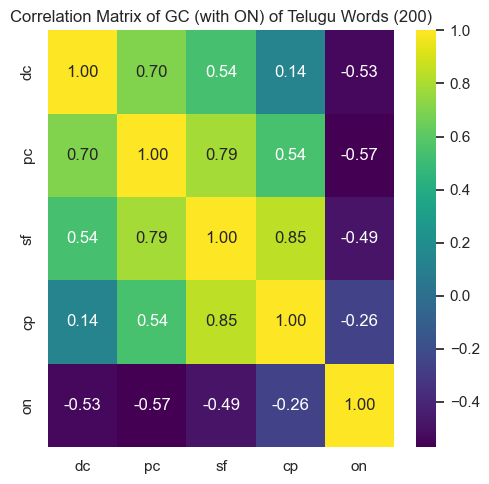

In [58]:
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(df[['dc', 'pc', 'sf', 'cp', 'on']].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of GC (with ON) of Telugu Words (200)')
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

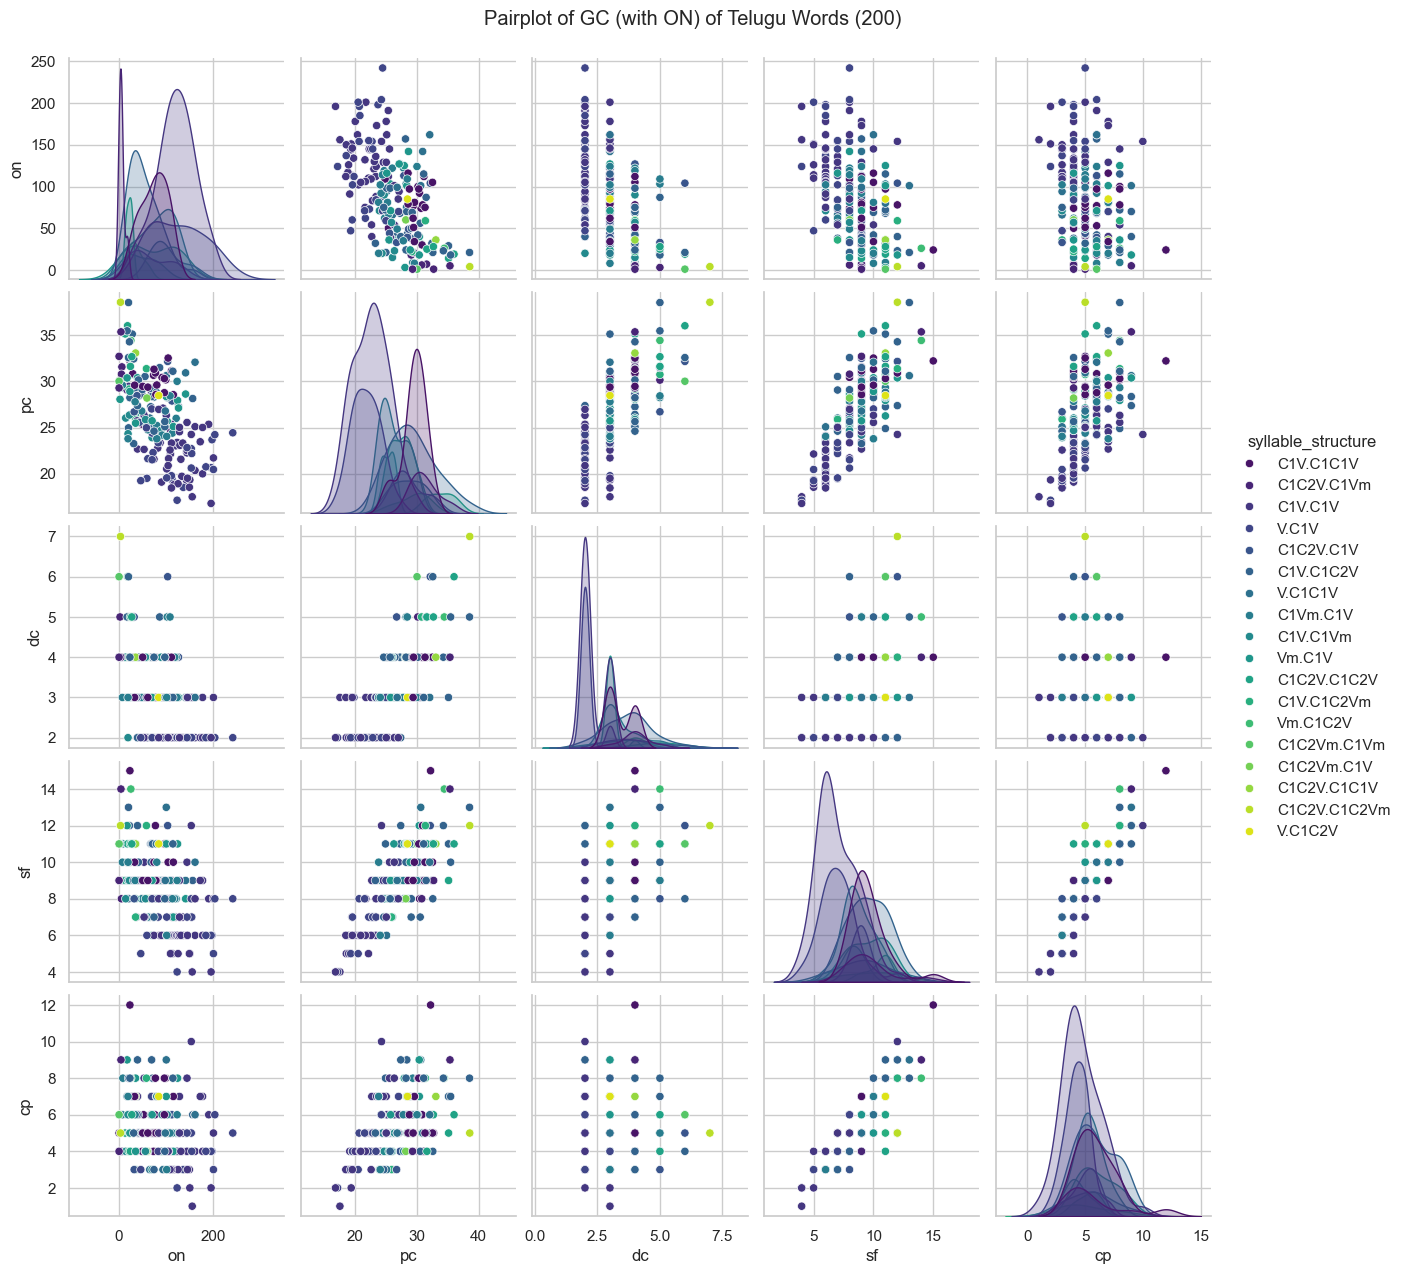

In [59]:
# plot
plt.figure(figsize=(10, 10))
sns.pairplot(df, hue='syllable_structure', palette='viridis')
plt.suptitle('Pairplot of GC (with ON) of Telugu Words (200)', y=1.02)
plt.show()

<Figure size 1000x1000 with 0 Axes>

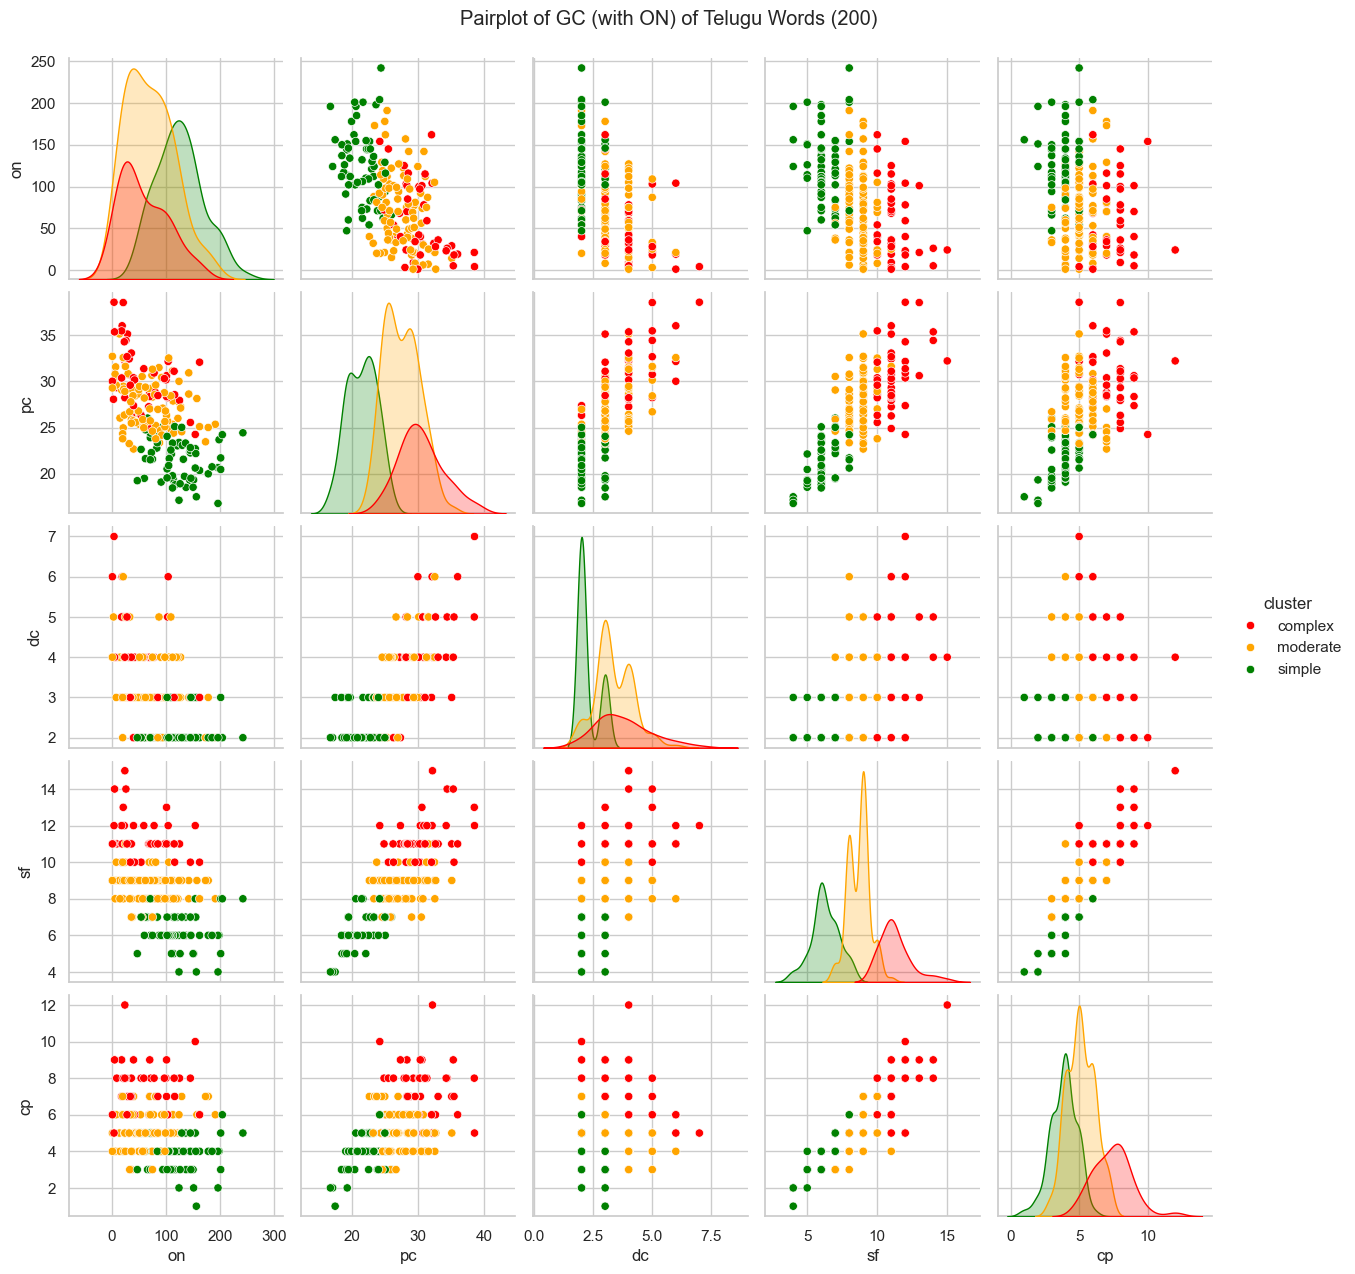

In [68]:
# plot
plt.figure(figsize=(10, 10))
sns.pairplot(df, hue='cluster', palette=dict(simple='green', moderate='orange', complex='red'))
plt.suptitle('Pairplot of GC (with ON) of Telugu Words (200)', y=1.02)
plt.show()

In [69]:
# print statistics

df.describe()

on          pc          dc          sf          cp
count  198.000000  198.000000  198.000000  198.000000  198.000000
mean    84.808081   26.335034    3.106061    8.505051    5.232323
std     51.544703    4.375795    0.999423    2.034593    1.675916
min      1.000000   16.792743    2.000000    4.000000    1.000000
25%     40.000000   23.333449    2.000000    7.000000    4.000000
50%     81.000000   26.030990    3.000000    9.000000    5.000000
75%    118.500000   29.363504    4.000000   10.000000    6.000000
max    242.000000   38.567430    7.000000   15.000000   12.000000

In [62]:
# # sort pd and csv

# df.sort_values(by='ONs', ascending=False).to_csv('words_measures_sorted.csv', index=False)